<h3><center>Intelligent Analysis of Medical Images</center></h3>
<h4><center>HW 2: Practical Part</center></h4>
<table width='100%' style="border: none;">
    <tr style="border: none; text-align: center;">
        <td style="border: none;"><h5>Javad Razi</h5></td>
        <td style="border: none;"><h5>401204354</h5></td>
        <td style="border: none;"><h5>j.razi@outlook.com</h5></td>
</table>
<hr/>
<br/>

# **Part A**

# Install and Import Libraries
In this cell, we will install, and import all the necessary libraries required for the implementation. This includes `torch` for model building and training, `torchvision` for datasets and data transforms, and additional libraries for metrics and visualization.

In [1]:
try:
    import gdown
except:
    %pip install gdown

try:
    import wandb
except:
    %pip install wandb
try:
    import torch
except:
    %pip install torch

try:
    import torchvision
except:
    %pip install torchvision

try:
    import pickle
except:
    %pip install pickle

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
import pandas as pd
import pickle
import wandb

# Downloading the Datasets

In [3]:
import os
import gdown

# Create the directory if it doesn't exist
if not os.path.exists('./datasets'):
    os.makedirs('./datasets')

# List of file IDs
file_ids = ['1i9Ei3QSmPBnYzqknvZPg_6TNsPomxQYG', '1-2cN6EuFQnIM53q1N3MQCVcoid1NPBWk', '1-0bl_TuSM-JQ4nCwAW7ySn3uYMAGlaz4']

file_names = ['train', 'test', 'validation']
# Download the files
for ind, file_id  in enumerate(file_ids):
    url = f'https://drive.google.com/uc?id={file_id}'
    output = f'./datasets/{file_names[ind]}.pickle'
    if not os.path.exists(output):
        gdown.download(url, output, quiet=False)


## Load The Pickle Files

In [4]:
import pickle

with open('./datasets/train.pickle', 'rb') as f:
    train_data = pickle.load(f)
with open('./datasets/test.pickle', 'rb') as f:
    test_data = pickle.load(f)
with open('./datasets/validation.pickle', 'rb') as f:
    validation_data = pickle.load(f)


## Initialize W&B (WandB)

In [5]:
# Offline and Online switches for wandb. Offline for now since we don't want to log anything yet.
import os

def wandb_off():
    os.environ['WANDB_MODE'] = 'online'
    os.environ['WANDB_SILENT'] = 'true'

def wandb_on():
    os.environ['WANDB_MODE'] = 'disabled'
    os.environ['WANDB_SILENT'] = 'false'


In [7]:
wandb.login(anonymous="allow")

True

In [8]:
wandb.init(project='mri-alexnet', entity='jrazi', name='jrazi-alexnet-from-scratch')

# AlexNet Architecture
Here we define the AlexNet architecture in PyTorch. We create a class `AlexNet` that inherits from `nn.Module` and define all the layers in the `__init__` method. The `forward` method dictates the data flow through the network.


In [9]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Dataset and Dataloaders
In this cell, we define our custom dataset class which will handle the MRI images. We'll also create the dataloaders for training, validation, and testing datasets.

In [10]:
class MRIDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        label -= 1
        if self.transform:
            image = self.transform(image)
        return image, label


# Define transforms for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227)), # AlexNet uses 227x227 inputs
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset instances
train_dataset = MRIDataset(train_data, transform=transform)
valid_dataset = MRIDataset(validation_data, transform=transform)
test_dataset = MRIDataset(test_data, transform=transform)

# Create dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


# Loss Function and Optimizer
In this cell, we define the loss function and the optimizer for our AlexNet model. We use Cross-Entropy Loss for our multi-class classification problem and the Adam optimizer with a learning rate of 1e-4.

In [11]:
model = AlexNet(num_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
Here we define the training loop where we train our AlexNet model. We keep track of the loss and accuracy for both the training and validation datasets.

In [12]:
# Training parameters
num_epochs = 10
train_steps = len(train_loader)
valid_steps = len(valid_loader)

# To track the training loss as the model trains
train_losses = []
# To track the validation loss as the model trains
valid_losses = []
# To track the average training loss per epoch as the model trains
avg_train_losses = []
# To track the average validation loss per epoch as the model trains
avg_valid_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    total_valid_loss = 0

    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        wandb.log({'train_loss': loss.item()})

    # Validation
    model.eval()  # Set model to evaluate mode
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_valid_loss += loss.item()
            wandb.log({'valid_loss': loss.item()})

    # Calculate average losses
    avg_train_loss = total_train_loss / train_steps
    avg_valid_loss = total_valid_loss / valid_steps

    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)

    # Log average losses to wandb
    wandb.log({'epoch': epoch, 'avg_train_loss': avg_train_loss, 'avg_valid_loss': avg_valid_loss})

    # Print training and validation progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/10], Train Loss: 0.9877, Valid Loss: 0.7443
Epoch [2/10], Train Loss: 0.6250, Valid Loss: 0.6167
Epoch [3/10], Train Loss: 0.5509, Valid Loss: 0.5347
Epoch [4/10], Train Loss: 0.4566, Valid Loss: 0.4943
Epoch [5/10], Train Loss: 0.4073, Valid Loss: 0.6788
Epoch [6/10], Train Loss: 0.3889, Valid Loss: 0.4106
Epoch [7/10], Train Loss: 0.3162, Valid Loss: 0.3133
Epoch [8/10], Train Loss: 0.2468, Valid Loss: 0.2723
Epoch [9/10], Train Loss: 0.2194, Valid Loss: 0.3687
Epoch [10/10], Train Loss: 0.1856, Valid Loss: 0.2521


# Training and Validation Loss Plots
In this cell, we visualize the training and validation loss over the epochs to understand the learning trend.

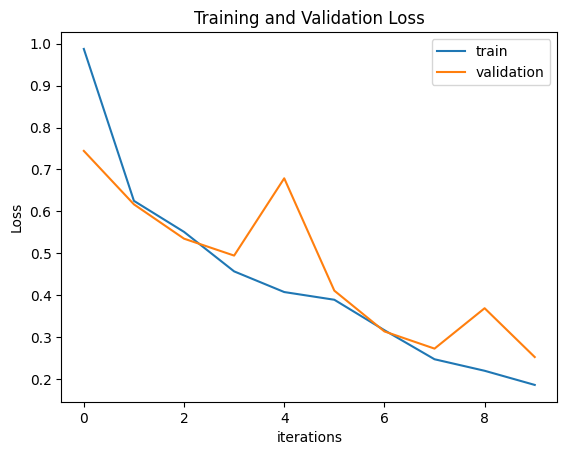

In [15]:
# plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(valid_losses,label="validation")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate the Model
In this cell, we evaluate the trained AlexNet model on the test dataset and calculate the classification metrics like accuracy, precision, recall, and F1 score.

In [16]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Log metrics to wandb
wandb.log({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1})

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Accuracy: 0.9251, Precision: 0.9252, Recall: 0.9251, F1-Score: 0.9251


In [17]:
# Create wandb metrics

from_scratch_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Log metrics to wandb for the from-scratch model
wandb.log({'from_scratch_accuracy': from_scratch_metrics['accuracy'],
           'from_scratch_precision': from_scratch_metrics['precision'],
           'from_scratch_recall': from_scratch_metrics['recall'],
           'from_scratch_f1_score': from_scratch_metrics['f1_score']})

In [18]:
wandb.finish()

# **Part B**

## Initialize WandB

In [19]:
wandb.init(project='mri-alexnet', entity='jrazi', name='jrazi-alexnet-pretrained')

# Load Pre-Trained AlexNet
In this cell, we load a pre-trained AlexNet model from torchvision's models. We then replace the final classification layer to match the number of classes in our dataset. We'll also define the loss function and optimizer for this pre-trained model.

In [20]:
from torchvision import models

# Load pre-trained AlexNet
pretrained_alexnet = models.alexnet(pretrained=True)
# Modify the classifier to match the number of classes
pretrained_alexnet.classifier[6] = nn.Linear(pretrained_alexnet.classifier[6].in_features, 3)
pretrained_alexnet = pretrained_alexnet.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_alexnet.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train and Validate Pre-Trained AlexNet
Here we train and validate the pre-trained AlexNet on our MRI dataset. We track the loss and accuracy for both the training and validation sets.

In [21]:
num_epochs = 10
train_steps = len(train_loader)
valid_steps = len(valid_loader)

pretrained_train_losses = []
pretrained_valid_losses = []
pretrained_avg_train_losses = []
pretrained_avg_valid_losses = []

# Training loop
for epoch in range(num_epochs):
    pretrained_alexnet.train()
    total_train_loss = 0
    total_valid_loss = 0

    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    pretrained_alexnet.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_alexnet(images)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / train_steps
    avg_valid_loss = total_valid_loss / valid_steps

    pretrained_train_losses.append(avg_train_loss)
    pretrained_valid_losses.append(avg_valid_loss)

    # Print training and validation progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/10], Train Loss: 0.4637, Valid Loss: 0.3354
Epoch [2/10], Train Loss: 0.2217, Valid Loss: 0.2494
Epoch [3/10], Train Loss: 0.1293, Valid Loss: 0.1821
Epoch [4/10], Train Loss: 0.0755, Valid Loss: 0.2356
Epoch [5/10], Train Loss: 0.0506, Valid Loss: 0.1471
Epoch [6/10], Train Loss: 0.0435, Valid Loss: 0.2293
Epoch [7/10], Train Loss: 0.0565, Valid Loss: 0.1607
Epoch [8/10], Train Loss: 0.0207, Valid Loss: 0.1307
Epoch [9/10], Train Loss: 0.0132, Valid Loss: 0.1328
Epoch [10/10], Train Loss: 0.0082, Valid Loss: 0.1232


# Visualize Loss and Accuracy for Pre-Trained AlexNet
We visualize the training and validation loss and accuracy for the pre-trained AlexNet using matplotlib.

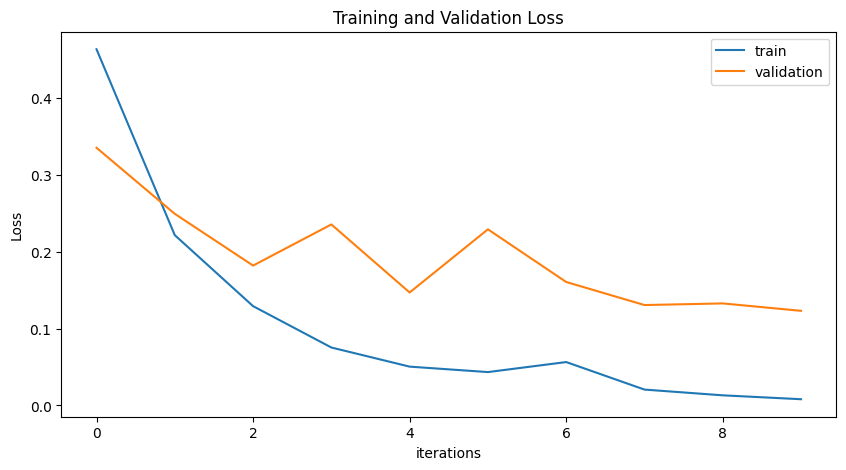

In [22]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(pretrained_train_losses,label="train")
plt.plot(pretrained_valid_losses,label="validation")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate Pre-Trained AlexNet
In this cell, we evaluate the pre-trained AlexNet on the test dataset and calculate the classification metrics.

In [23]:
# Evaluate on test set
pretrained_alexnet.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_alexnet(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Accuracy: 0.9642, Precision: 0.9644, Recall: 0.9642, F1-Score: 0.9642


In [24]:
pretrained_metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Log metrics to wandb for the pre-trained model
wandb.log({'pretrained_accuracy': pretrained_metrics['accuracy'],
           'pretrained_precision': pretrained_metrics['precision'],
           'pretrained_recall': pretrained_metrics['recall'],
           'pretrained_f1_score': pretrained_metrics['f1_score']})

# Comparison of From-Scratch and Pre-Trained AlexNet
In this cell, we compare the performance of our from-scratch AlexNet with the pre-trained AlexNet on our dataset, based on the metrics we calculated.

In [25]:
wandb.log({
    'from_scratch_accuracy': from_scratch_metrics['accuracy'],
    'pretrained_accuracy': pretrained_metrics['accuracy'],
    'from_scratch_precision': from_scratch_metrics['precision'],
    'pretrained_precision': pretrained_metrics['precision'],
    'from_scratch_recall': from_scratch_metrics['recall'],
    'pretrained_recall': pretrained_metrics['recall'],
    'from_scratch_f1_score': from_scratch_metrics['f1_score'],
    'pretrained_f1_score': pretrained_metrics['f1_score']
})

# Print out for inspection
print("From-Scratch AlexNet Metrics:")
print(f"Accuracy: {from_scratch_metrics['accuracy']:.4f}")
print(f"Precision: {from_scratch_metrics['precision']:.4f}")
print(f"Recall: {from_scratch_metrics['recall']:.4f}")
print(f"F1-Score: {from_scratch_metrics['f1_score']:.4f}\n")

print("Pre-Trained AlexNet Metrics:")
print(f"Accuracy: {pretrained_metrics['accuracy']:.4f}")
print(f"Precision: {pretrained_metrics['precision']:.4f}")
print(f"Recall: {pretrained_metrics['recall']:.4f}")
print(f"F1-Score: {pretrained_metrics['f1_score']:.4f}")

From-Scratch AlexNet Metrics:
Accuracy: 0.9251
Precision: 0.9252
Recall: 0.9251
F1-Score: 0.9251

Pre-Trained AlexNet Metrics:
Accuracy: 0.9642
Precision: 0.9644
Recall: 0.9642
F1-Score: 0.9642


In [26]:
wandb.finish()

# **Part C**

# Implementing Supervised Contrastive Loss
Here We'll define the new loss function and update our training loop accordingly.

In [27]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        labels = labels.contiguous().view(-1, 1)
        batch_size = features.shape[0]

        mask = torch.eye(batch_size).bool().to(features.device)
        features = F.normalize(features, dim=1)
        sim_matrix = torch.matmul(features, features.T) / self.temperature

        # Create masks
        pos_mask = labels.eq(labels.T) & ~mask
        neg_mask = ~labels.eq(labels.T)

        # Select out positive and negative similarities
        pos_sim = sim_matrix[pos_mask]
        neg_sim = sim_matrix[neg_mask]

        # Calculate logits and their corresponding labels
        logits = torch.cat((pos_sim, neg_sim), dim=0).unsqueeze(1)
        labels = torch.cat((torch.ones(pos_sim.size(0), device=features.device),
                            torch.zeros(neg_sim.size(0), device=features.device)), dim=0)

        # Calculate the contrastive loss as a binary cross-entropy loss
        loss = F.binary_cross_entropy_with_logits(logits, labels.unsqueeze(1), reduction='mean')

        return loss


## Initialize WandB

In [28]:
wandb.init(project='mri-alexnet', entity='jrazi', name='jrazi-alexnet-supervised-contrastive-loss')

# Retrain & Fine-Tune with Categorical Cross-Entropy
Here, we retrain the from-scratch AlexNet using Supervised Contrastive Loss for 10 epochs followed by fine-tuning with Cross-Entropy Loss for 5 epochs.

In [29]:
model = AlexNet(num_classes=3)
model.to(device)
contrastive_loss_function = SupervisedContrastiveLoss()
cross_entropy_loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training parameters
contrastive_epochs = 10
cross_entropy_epochs = 5

# Training loop for Supervised Contrastive Loss
for epoch in range(contrastive_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = contrastive_loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        # Log batch loss
        wandb.log({'contrastive_train_loss': loss.item()})

    # Calculate average losses
    avg_train_loss = total_train_loss / train_steps
    train_losses.append(avg_train_loss)

    # Log average loss to wandb
    wandb.log({'epoch': epoch, 'contrastive_avg_train_loss': avg_train_loss})

    # Print training progress
    print(f'Contrastive Epoch [{epoch+1}/{contrastive_epochs}], Train Loss: {avg_train_loss:.4f}')

# Transition to Cross-Entropy Loss training
wandb.log({'phase': 'cross_entropy_loss_training'})

# Training loop for Cross-Entropy Loss
for epoch in range(cross_entropy_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    total_valid_loss = 0

    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = cross_entropy_loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        # Log batch loss
        wandb.log({'cross_entropy_train_loss': loss.item()})

    # Validation
    model.eval()  # Set model to evaluate mode
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = cross_entropy_loss_function(outputs, labels)
            total_valid_loss += loss.item()
            # Log batch validation loss
            wandb.log({'cross_entropy_valid_loss': loss.item()})

    # Calculate average losses
    avg_train_loss = total_train_loss / train_steps
    avg_valid_loss = total_valid_loss / valid_steps
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)

    # Log average losses to wandb
    wandb.log({'epoch': epoch + contrastive_epochs,  # offset by the number of contrastive epochs
               'cross_entropy_avg_train_loss': avg_train_loss,
               'cross_entropy_avg_valid_loss': avg_valid_loss})

    # Print training and validation progress
    print(f'Cross-Entropy Epoch [{epoch+1}/{cross_entropy_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Contrastive Epoch [1/10], Train Loss: 5.9997
Contrastive Epoch [2/10], Train Loss: 3.0649
Contrastive Epoch [3/10], Train Loss: 2.7013
Contrastive Epoch [4/10], Train Loss: 2.6845
Contrastive Epoch [5/10], Train Loss: 2.6496
Contrastive Epoch [6/10], Train Loss: 2.7264
Contrastive Epoch [7/10], Train Loss: 2.6145
Contrastive Epoch [8/10], Train Loss: 2.6442
Contrastive Epoch [9/10], Train Loss: 2.5948
Contrastive Epoch [10/10], Train Loss: 2.6041
Cross-Entropy Epoch [1/5], Train Loss: 1.1397, Valid Loss: 0.8856
Cross-Entropy Epoch [2/5], Train Loss: 0.7164, Valid Loss: 0.6183
Cross-Entropy Epoch [3/5], Train Loss: 0.5347, Valid Loss: 0.5483
Cross-Entropy Epoch [4/5], Train Loss: 0.4748, Valid Loss: 0.4679
Cross-Entropy Epoch [5/5], Train Loss: 0.4506, Valid Loss: 0.4435


# Visualizing Loss and Accuracy Plot for Train & Fine-Tuning

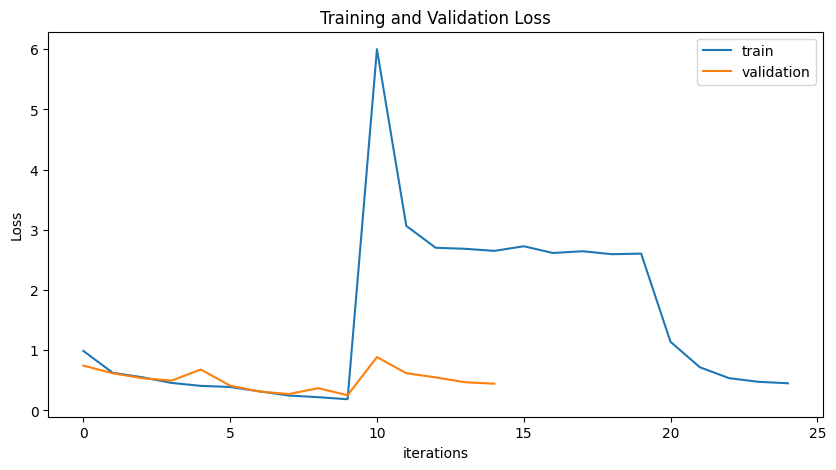

In [30]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="train")
plt.plot(valid_losses,label="validation")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate Fine-Tuned Model
In this cell, we evaluate the fine-tuned model on the test dataset using our classification metrics.

In [31]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Log metrics to wandb
wandb.log({
    'test_accuracy': accuracy,
    'test_precision': precision,
    'test_recall': recall,
    'test_f1_score': f1
})

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Accuracy: 0.8143, Precision: 0.8074, Recall: 0.8143, F1-Score: 0.8057


In [32]:
# Finish the wandb run after evaluation
wandb.finish()